In [ ]:
import pandas as pd
import seaborn as sns
import pandas_profiling
from matplotlib import pyplot as plt
import numpy as np
from sklearn import preprocessing

import warnings

from pandas.core.common import SettingWithCopyWarning

# warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

df = pd.read_csv('train/train.csv')
df.info()

total_df = df.copy()

dfs_test = []

for i in range(81):
    temp_df = pd.read_csv(f"test/{i}.csv")
    dfs_test.append(temp_df.copy())
    total_df = pd.concat([total_df, temp_df])
    
dfs_valid = []

for i in range(81):
    temp_df = pd.read_csv(f"test/{i}.csv")
    dfs_valid.append(temp_df.copy())

# index = 8

"""
Hour - 시간
Minute - 분
DHI - 수평면 산란일사량(Diffuse Horizontal Irradiance (W/m2))
DNI - 직달일사량(Direct Normal Irradiance (W/m2))
WS - 풍속(Wind Speed (m/s))
RH - 상대습도(Relative Humidity (%))
T - 기온(Temperature (Degree C))
Target - 태양광 발전량 (kW)
"""

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Day     52560 non-null  int64  
 1   Hour    52560 non-null  int64  
 2   Minute  52560 non-null  int64  
 3   DHI     52560 non-null  int64  
 4   DNI     52560 non-null  int64  
 5   WS      52560 non-null  float64
 6   RH      52560 non-null  float64
 7   T       52560 non-null  int64  
 8   TARGET  52560 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 3.6 MB


'\nHour - 시간\nMinute - 분\nDHI - 수평면 산란일사량(Diffuse Horizontal Irradiance (W/m2))\nDNI - 직달일사량(Direct Normal Irradiance (W/m2))\nWS - 풍속(Wind Speed (m/s))\nRH - 상대습도(Relative Humidity (%))\nT - 기온(Temperature (Degree C))\nTarget - 태양광 발전량 (kW)\n'

In [ ]:
import math

def make_feature(df):
    df['Minute'].replace(30, 0.5, inplace=True)
    df['Time'] = df['Hour'] + df['Minute']
    
    df['Time_x'] = np.cos((df['Time'] * 2 * np.pi) / 24.0)
    df['Time_y'] = np.sin((df['Time'] * 2 * np.pi) / 24.0)
    
    df = df.drop(['Hour', 'Minute', 'Time'], axis=1)
    
    df['Origin_TARGET'] = df['TARGET'].copy()
    
    df['GHI'] = df['DHI'] + df['DNI']
    df['RDHNI'] = df['GHI'].apply(lambda x : x**0.5)
    df['GHI_East'] = df['DHI'] + df['DNI'] * math.cos(0.436332)
    df['GHI_West'] = df['DHI'] - df['DNI'] * math.cos(0.436332)
#====================================================================================
    df['Lower_Cloud'] = 2.5 * df['RH'] / 100 - 1.5
    df['Middle_Cloud'] = 4 * df['RH'] / 100 - 3.0
#====================================================================================
    b = 17.62
    c = 243.12
    df['gamma'] = (b * df['T'] /(c + df['T'])) + (df['RH'] / 100.0).apply(lambda x: math.log(x))
    df['DD'] = (c * df['gamma']) / (b - df['gamma'])

    df.drop('gamma', axis=1, inplace=True)       
#=====================================================================================
    hr_rad = []
    hr_list = []
    for i in range(int(len(df)/48)):
        count = 0
        for j in range(48):
            if df.iloc[48*i + j, 6] != 0 : 
                count = count + 1
                hr_rad.append(count)
            else :
                hr_rad.append(0)
        hr = count * 0.5
        for j in range(48):
            hr_list.append(hr)
    df['HR'] = hr_list
    df['HR_RAD'] = hr_rad

    I0 = 1355
    d = -17.853
    k = 0.843
    B0 = 0.5598
    B1 = 0.4982
    B2 = -0.6762
    B3 = 0.02842
    B4 = -0.00317
    B5 = 0.014
    h = 180 / (df['HR']*2) * df['HR_RAD'] / 360 * 2 * math.pi

    df['T_3lag'] = df['T'].shift(6)

    df['I'] = (I0 * h.apply(math.sin) * (B0 + B1*df['Lower_Cloud'] + B2*df['Lower_Cloud']*df['Lower_Cloud'] + B3*(df['T'] - df['T_3lag']) + B4*df['RH'] + B5*df['WS']) + d) / k

    df.drop(['T_3lag', 'HR_RAD'], axis=1, inplace=True)

    # 0처리 고민할것

    df['I'] = df['I'].apply(lambda x : 0 if x<0 else x)

    df = df.fillna(0)
#=====================================================================================================================================================
    return df

def preprocess(df, total_df):
    df = make_feature(df.copy())
    total_df = make_feature(total_df.copy())
    
    normalize_column = {
        'DHI': 'MM',
        'DNI': 'MM',
        'WS': 'MM',
        'RH': 'MM',
        'T': 'MM',
        'TARGET': 'MM',
        'GHI': 'MM',
        'RDHNI': 'MM',
        'GHI_East': 'MM',
        'GHI_West': 'MM',
        'Lower_Cloud': 'MM',
        'Middle_Cloud': 'MM',
        'DD': 'MM',
        'HR':'MM',
        'I' : 'MM',
    }

    for c, t in normalize_column.items():
        if t == 'MM':
            scaler = preprocessing.MinMaxScaler()
        else:
            scaler = preprocessing.StandardScaler()
            
        x = df[[c]].copy() #returns a numpy array
        scaler.fit(total_df[[c]])
        df[c] = scaler.transform(x)
    
    return df

In [ ]:
df = preprocess(df, total_df)
temp = []
for df_valid in dfs_valid:
    temp.append(preprocess(df_valid, total_df))
dfs_valid = temp

In [ ]:
df.head(5)

,Day,DHI,DNI,WS,RH,T,TARGET,Time_x,Time_y,Origin_TARGET,GHI,RDHNI,GHI_East,GHI_West,Lower_Cloud,Middle_Cloud,DD,HR,I
0,0,0.0,0.0,0.125000,0.674834,0.125673,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.687483,0.674834,0.674834,0.227748,0.071429,0.0
1,0,0.0,0.0,0.125000,0.674624,0.125673,0.0,0.991445,0.130526,0.0,0.0,0.0,0.0,0.687483,0.674624,0.674624,0.227668,0.071429,0.0
2,0,0.0,0.0,0.133333,0.703229,0.125673,0.0,0.965926,0.258819,0.0,0.0,0.0,0.0,0.687483,0.703229,0.703229,0.238287,0.071429,0.0
3,0,0.0,0.0,0.133333,0.702913,0.125673,0.0,0.923880,0.382683,0.0,0.0,0.0,0.0,0.687483,0.702913,0.702913,0.238172,0.071429,0.0
4,0,0.0,0.0,0.133333,0.739194,0.125673,0.0,0.866025,0.500000,0.0,0.0,0.0,0.0,0.687483,0.739194,0.739194,0.251139,0.071429,0.0


In [ ]:
def make_train_data_set(df, ins_day, outs_day, is_second_day=False, is_valid=False, none_zero=False):
#     df = df.astype('float')
    ins_datas = df[['DHI', 'DNI', 'RH', 'T', 'TARGET', 'Time_x', 'Time_y', 'GHI',
                   'RDHNI', 'GHI_East', 'GHI_West', 'Lower_Cloud', 'Middle_Cloud', 'DD', 'HR', 'I']].values.astype('float16')
#     ins_agg_datas = df.drop(columns=['pca_1', 'pca_2', 'pca_3', 'Time_x', 'Time_y', 'Origin_TARGET']).values
    outs_datas = df[['Origin_TARGET']].values.astype('float16')
    
    ins = []
#     ins_agg = []
    outs = []
    
        #     pca_1	pca_2	pca_3	Origin_TARGET	Time_x	Time_y	    
        # 4.5~19.5
        
    if not is_second_day:
        for i in range(len(df) - (ins_day + outs_day)*48):
            ins.append([ins_datas[i:i + ins_day*48]])
            if none_zero:
                outs.append([outs_datas[i + 9 + ins_day*48:i - 8 + (ins_day+outs_day)*48]])
            else:
                outs.append([outs_datas[i + ins_day*48:i + (ins_day+outs_day)*48]])
    else:
        for i in range(len(df) - (ins_day + outs_day + 1)*48):
            ins.append([ins_datas[i:i + ins_day*48]])
            if none_zero:
                outs.append([outs_datas[i + 9 + (ins_day+1)*48:i - 8 + (ins_day+outs_day+1)*48]])
            else:       
                outs.append([outs_datas[i + (ins_day+1)*48:i + (ins_day+outs_day+1)*48]])

        
    return np.concatenate(ins), np.concatenate(outs)

# ins, outs = make_train_data_set(df)

In [ ]:
x_train, y_train = make_train_data_set(df, ins_day=3, outs_day=1)
x_2_train, y_2_train = make_train_data_set(df, ins_day=3, outs_day=1, is_second_day=True)

x_valids = []
y_valids = []
x_2_valids = []
y_2_valids = []

for i in range(len(dfs_valid)):
    x, y = make_train_data_set(dfs_valid[i], ins_day=3, outs_day=1)
    x_valids.append(x)
    y_valids.append(y)
    
    x_2,y_2 = make_train_data_set(dfs_valid[i], ins_day=3, outs_day=1, is_second_day=True)
    x_2_valids.append(x_2)
    y_2_valids.append(y_2)

x_train.shape, y_train.shape, x_2_train.shape, y_2_train.shape

x_valid = np.concatenate(x_valids)
y_valid = np.concatenate(y_valids)
x_2_valid = np.concatenate(x_2_valids)
y_2_valid = np.concatenate(y_2_valids)

x_valid.shape, y_valid.shape, x_2_valid.shape, y_2_valid.shape

((11664, 144, 16), (11664, 48, 1), (7776, 144, 16), (7776, 48, 1))

In [ ]:
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten, GRU
from keras.layers import LSTM, Input, Conv1D, Dropout
from keras.layers import RepeatVector, Bidirectional
from keras.layers import TimeDistributed, Concatenate, Lambda
from keras import Model
from keras import backend as K
import tensorflow as tf
from keras import optimizers

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

# 7일의 데이터로 2일을 예측
# 1일 = 48개의 관측값
# 7일 = 7 * 48 = 336
# 2일 = 2 * 48 = 96
def pinball_loss(tau):
    def loss(y_true, y_pred):
        err = y_true - y_pred
        return K.mean(K.maximum(tau * err, (tau - 1) * err))
    return loss


def build_model(tau, lr=0.001, use_summary=True, use_mse=False):
    opt = optimizers.RMSprop(lr=lr)
    
    x_lstm = Input(shape=(144, 16))
    
    x_1 = Lambda(lambda x: x[:,:48,:])(x_lstm)
    x_2 = Lambda(lambda x: x[:,48:96,:])(x_lstm)
    x_3 = Lambda(lambda x: x[:,96:,:])(x_lstm)
    
    
    x_1 = LSTM(64, return_sequences=True)(x_1)
    x_1 = LSTM(64, return_sequences=False)(x_1)
    x_2 = LSTM(64, return_sequences=True)(x_2)
    x_2 = LSTM(64, return_sequences=False)(x_2)
    x_3 = LSTM(64, return_sequences=True)(x_3)
    x_3 = LSTM(64, return_sequences=False)(x_3)
    
    x = Concatenate()([x_1, x_2, x_3])
    x = Dense(100)(x)
    x_out = Dense(48, activation = 'relu')(x)

    model = Model(x_lstm, x_out)
    
    if use_mse:
        model.compile(loss='mse', optimizer=opt)
    else:
        model.compile(loss=pinball_loss(tau), optimizer=opt)
        
    if use_summary:
        model.summary()
    
    return model

# taus = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
# taus = [0.1,0.3,0.5,0.7,0.9]


# main_model_year_1_3 = build_model(0.5, lr=0.001, use_summary=False, use_mse=True)
# main_model_year_2_3 = build_model(0.5, lr=0.001, use_summary=False, use_mse=True)

In [ ]:
from keras.callbacks import EarlyStopping

main_model = build_model(0.5, lr=0.001, use_summary=True, use_mse=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, restore_best_weights=True, patience=10)

print(f'#### Model ####')
his = main_model.fit(x_train, y_train,
    epochs=100, batch_size=2000, validation_data=(x_valid, y_valid), verbose=1, callbacks=[es])


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 144, 16)]    0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 48, 16)       0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 48, 16)       0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 48, 16)       0           input_1[0][0]                    
______________________________________________________________________________________________

In [ ]:
from keras.callbacks import EarlyStopping

taus = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
models=[]

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, restore_best_weights=True, patience=10)

for i in range(len(taus)):
    model = build_model(taus[i], lr=0.0001, use_summary=False, use_mse=False)
    model.set_weights(main_model.get_weights())
    model.fit(x_train, y_train,
              epochs=100, batch_size=2000, validation_data=(x_valid, y_valid), verbose=1, callbacks=[es])
    models.append(model)


Epoch 1/100
27/27 [==============================] - 10s 131ms/step - loss: 1.9106 - val_loss: 1.6885
Epoch 2/100
27/27 [==============================] - 2s 69ms/step - loss: 1.4185 - val_loss: 1.5680
Epoch 3/100
27/27 [==============================] - 2s 69ms/step - loss: 1.3840 - val_loss: 1.5437
Epoch 4/100
27/27 [==============================] - 2s 69ms/step - loss: 1.3631 - val_loss: 1.4824
Epoch 5/100
27/27 [==============================] - 2s 69ms/step - loss: 1.3497 - val_loss: 1.5232
Epoch 6/100
27/27 [==============================] - 2s 69ms/step - loss: 1.3431 - val_loss: 1.4910
Epoch 7/100
27/27 [==============================] - 2s 70ms/step - loss: 1.3382 - val_loss: 1.4819
Epoch 8/100
27/27 [==============================] - 2s 69ms/step - loss: 1.3327 - val_loss: 1.5000
Epoch 9/100
27/27 [==============================] - 2s 69ms/step - loss: 1.3287 - val_loss: 1.5377
Epoch 10/100
27/27 [==============================] - 2s 69ms/step - loss: 1.3294 - val_loss: 1.49

In [ ]:
from keras.callbacks import EarlyStopping

main_model_2 = build_model(0.5, lr=0.001, use_summary=True, use_mse=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, restore_best_weights=True, patience=10)

print(f'#### Model ####')
his = main_model_2.fit(x_2_train, y_2_train,
    epochs=100, batch_size=2000, validation_data=(x_2_valid, y_2_valid), verbose=1, callbacks=[es])


Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 144, 16)]    0                                            
__________________________________________________________________________________________________
lambda_30 (Lambda)              (None, 48, 16)       0           input_11[0][0]                   
__________________________________________________________________________________________________
lambda_31 (Lambda)              (None, 48, 16)       0           input_11[0][0]                   
__________________________________________________________________________________________________
lambda_32 (Lambda)              (None, 48, 16)       0           input_11[0][0]                   
___________________________________________________________________________________________

In [ ]:
from keras.callbacks import EarlyStopping

taus = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
models_2=[]

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, restore_best_weights=True, patience=10)

for i in range(len(taus)):
    model = build_model(taus[i], lr=0.0001, use_summary=False, use_mse=False)
    model.set_weights(main_model_2.get_weights())
    model.fit(x_2_train, y_2_train,
              epochs=100, batch_size=2000, validation_data=(x_2_valid, y_2_valid), verbose=1, callbacks=[es])
    models_2.append(model)


Epoch 1/100
27/27 [==============================] - 10s 128ms/step - loss: 2.2771 - val_loss: 1.9543
Epoch 2/100
27/27 [==============================] - 2s 67ms/step - loss: 1.5276 - val_loss: 1.6774
Epoch 3/100
27/27 [==============================] - 2s 67ms/step - loss: 1.4487 - val_loss: 1.6366
Epoch 4/100
27/27 [==============================] - 2s 67ms/step - loss: 1.4347 - val_loss: 1.6498
Epoch 5/100
27/27 [==============================] - 2s 67ms/step - loss: 1.4275 - val_loss: 1.6529
Epoch 6/100
27/27 [==============================] - 2s 67ms/step - loss: 1.4268 - val_loss: 1.6255
Epoch 7/100
27/27 [==============================] - 2s 67ms/step - loss: 1.4233 - val_loss: 1.6305
Epoch 8/100
27/27 [==============================] - 2s 68ms/step - loss: 1.4236 - val_loss: 1.6623
Epoch 9/100
27/27 [==============================] - 2s 67ms/step - loss: 1.4159 - val_loss: 1.7195
Epoch 10/100
27/27 [==============================] - 2s 67ms/step - loss: 1.4174 - val_loss: 1.62

In [ ]:
def make_test_data_set(df, ins_day, outs_day, is_second_day=False, is_valid=False, none_zero=False):
    ins_datas = df[['DHI', 'DNI', 'RH', 'T', 'TARGET', 'Time_x', 'Time_y', 'GHI',
                   'RDHNI', 'GHI_East', 'GHI_West', 'Lower_Cloud', 'Middle_Cloud', 'DD', 'RH', 'I']].values.astype('float16')
    
    ins = []
        
#     for i in range(len(df) - (ins_day + outs_day)*48):
    ins.append([ins_datas[-(ins_day*48):]])
        
    return np.concatenate(ins)

In [ ]:
temp = []
for df_test in dfs_test:
    temp.append(preprocess(df_test, total_df))
dfs_test = temp

x_test = []

for i in range(len(dfs_test)):
    x = make_test_data_set(dfs_test[i], ins_day=3, outs_day=1)
    x_test.append(x)
    
x_test = np.concatenate(x_test)

In [ ]:
x_test[0].shape

(144, 16)

In [ ]:
df_result = pd.DataFrame()
df_2_result = pd.DataFrame()
for i in range(9):
    print(taus[i])
    res = pd.Series(models[i].predict(x_test).flatten())
    res_2 = pd.Series(models_2[i].predict(x_test).flatten())
    df_result = pd.concat([df_result,res],axis=1)
    df_2_result = pd.concat([df_2_result,res_2],axis=1)

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


In [ ]:
import warnings

from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

df_sample = pd.read_csv('sample_submission.csv')


columns = ['q_0.1', 'q_0.2', 'q_0.3', 'q_0.4', 'q_0.5', 'q_0.6', 'q_0.7', 'q_0.8', 'q_0.9']
# columns = ['q_0.1', 'q_0.3', 'q_0.5', 'q_0.7', 'q_0.9']

submission = pd.read_csv('sample_submission.csv')

submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = df_result.values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = df_2_result.values
    
submission.to_csv(f'lstm_try6.csv', index=False) 

In [ ]:
df_result.values

array([], shape=(0, 0), dtype=float64)

In [ ]:
a = pd.read_csv('lstm_try6.csv')

In [ ]:
b = a[0:48]

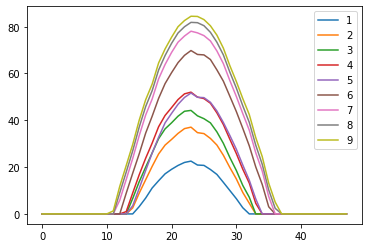

In [ ]:
plt.plot(b['q_0.1'], label='1')
plt.plot(b['q_0.2'], label='2')
plt.plot(b['q_0.3'], label='3')
plt.plot(b['q_0.4'], label='4')
plt.plot(b['q_0.5'], label='5')
plt.plot(b['q_0.6'], label='6')
plt.plot(b['q_0.7'], label='7')
plt.plot(b['q_0.8'], label='8')
plt.plot(b['q_0.9'], label='9')
plt.legend()
plt.show()

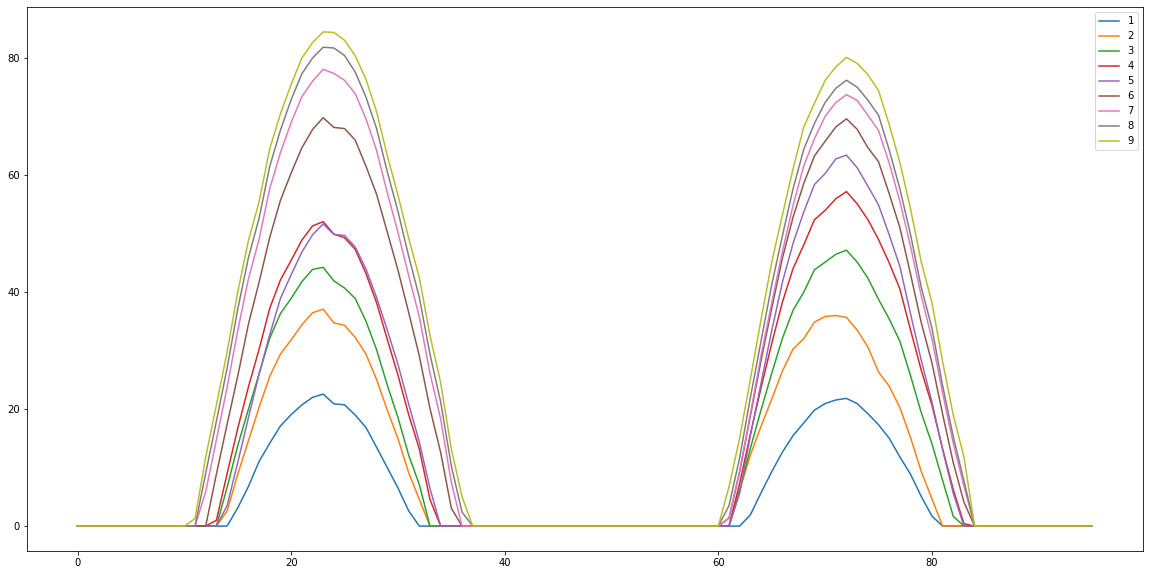

In [ ]:
b = a[0:96]
plt.figure(figsize=(20, 10))
plt.plot(b['q_0.1'], label='1')
plt.plot(b['q_0.2'], label='2')
plt.plot(b['q_0.3'], label='3')
plt.plot(b['q_0.4'], label='4')
plt.plot(b['q_0.5'], label='5')
plt.plot(b['q_0.6'], label='6')
plt.plot(b['q_0.7'], label='7')
plt.plot(b['q_0.8'], label='8')
plt.plot(b['q_0.9'], label='9')
plt.legend()
plt.show()

In [ ]:
c = pd.read_csv('/content/lstm_model_copy_2 (1).csv')

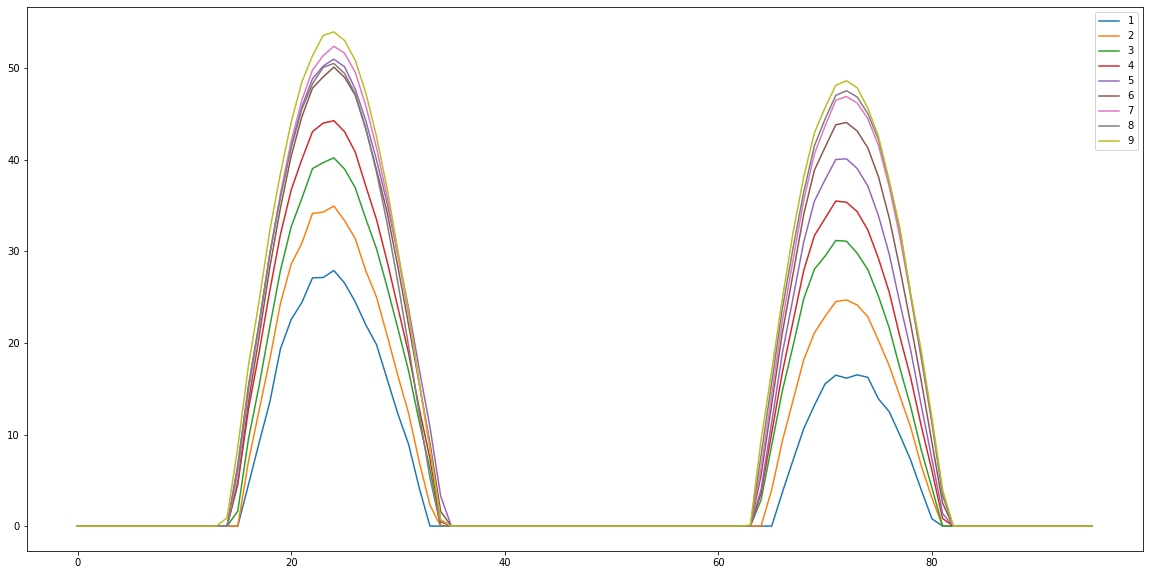

In [ ]:
d = c[0:96]
plt.figure(figsize=(20, 10))
plt.plot(d['q_0.1'], label='1')
plt.plot(d['q_0.2'], label='2')
plt.plot(d['q_0.3'], label='3')
plt.plot(d['q_0.4'], label='4')
plt.plot(d['q_0.5'], label='5')
plt.plot(d['q_0.6'], label='6')
plt.plot(d['q_0.7'], label='7')
plt.plot(d['q_0.8'], label='8')
plt.plot(d['q_0.9'], label='9')
plt.legend()
plt.show()

In [ ]:
e = pd.read_csv('BiLSTM.csv')

In [ ]:
a.describe()

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
count,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000
mean,6.656181,12.646737,15.225514,17.423783,19.011032,20.599106,21.534852,22.464181,23.357260
std,10.074790,17.392567,20.353378,22.864498,25.117313,26.648143,27.618265,28.527589,29.170223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,13.636363,27.141282,33.220396,38.109374,41.342604,45.091545,46.885122,48.728059,50.458776
max,43.597797,66.708298,73.379272,76.052757,80.926201,82.068810,84.029884,86.503899,88.890434


In [ ]:
c.describe()

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
count,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000
mean,8.399156,12.808520,16.139653,18.410008,20.456217,21.511086,22.403952,23.088132,23.997476
std,13.287239,18.344256,22.136877,24.857232,27.266995,28.416782,29.339047,29.981940,30.763590
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,15.367132,25.200690,31.945301,36.435277,40.475208,42.714224,44.695996,45.879952,47.662293
max,61.283031,74.946716,85.270432,90.596466,95.767166,98.141296,99.178276,99.178238,99.108994


In [ ]:
e.describe()

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
count,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000
mean,9.395751,13.550892,16.113491,17.870880,19.185322,20.611564,21.748380,22.762715,23.649329
std,14.710266,19.649947,22.564964,24.397492,25.841227,27.448770,28.540377,29.515085,30.309296
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035710
75%,16.854636,25.784514,31.428707,35.494731,38.344229,41.177907,43.666090,45.753454,47.322420
max,74.015556,82.007957,89.191048,93.724052,97.416893,102.344078,102.566208,101.820107,102.740379


In [ ]:
f = pd.read_csv('lstm_model_copy_7.csv')
f.describe()

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
count,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000
mean,7.706671,12.906618,15.520909,17.909850,19.465872,20.942682,22.050225,22.854489,24.190004
std,12.127323,18.528526,21.864631,24.204932,26.008588,27.704157,28.907183,29.660954,30.909337
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,14.485068,25.041676,30.350660,35.758694,38.994934,42.001939,44.282204,46.087575,48.531678
max,61.627308,84.049454,92.957573,92.466347,96.456062,99.783905,99.542236,98.514107,99.891518


In [ ]:
c.describe()

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
count,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000
mean,8.399156,12.808520,16.139653,18.410008,20.456217,21.511086,22.403952,23.088132,23.997476
std,13.287239,18.344256,22.136877,24.857232,27.266995,28.416782,29.339047,29.981940,30.763590
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,15.367132,25.200690,31.945301,36.435277,40.475208,42.714224,44.695996,45.879952,47.662293
max,61.283031,74.946716,85.270432,90.596466,95.767166,98.141296,99.178276,99.178238,99.108994


In [ ]:
g.describe()

In [ ]:
import pandas as pd
import seaborn as sns
import pandas_profiling
from matplotlib import pyplot as plt
import numpy as np
from sklearn import preprocessing

import warnings

from pandas.core.common import SettingWithCopyWarning

# warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

df = pd.read_csv('train/train.csv')
df.info()

total_df = df.copy()

dfs_test = []

for i in range(81):
    temp_df = pd.read_csv(f"test/{i}.csv")
    dfs_test.append(temp_df.copy())
    total_df = pd.concat([total_df, temp_df])
    
dfs_valid = []

for i in range(81):
    temp_df = pd.read_csv(f"test/{i}.csv")
    dfs_valid.append(temp_df.copy())

# index = 8

"""
Hour - 시간
Minute - 분
DHI - 수평면 산란일사량(Diffuse Horizontal Irradiance (W/m2))
DNI - 직달일사량(Direct Normal Irradiance (W/m2))
WS - 풍속(Wind Speed (m/s))
RH - 상대습도(Relative Humidity (%))
T - 기온(Temperature (Degree C))
Target - 태양광 발전량 (kW)
"""

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Day     52560 non-null  int64  
 1   Hour    52560 non-null  int64  
 2   Minute  52560 non-null  int64  
 3   DHI     52560 non-null  int64  
 4   DNI     52560 non-null  int64  
 5   WS      52560 non-null  float64
 6   RH      52560 non-null  float64
 7   T       52560 non-null  int64  
 8   TARGET  52560 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 3.6 MB


'\nHour - 시간\nMinute - 분\nDHI - 수평면 산란일사량(Diffuse Horizontal Irradiance (W/m2))\nDNI - 직달일사량(Direct Normal Irradiance (W/m2))\nWS - 풍속(Wind Speed (m/s))\nRH - 상대습도(Relative Humidity (%))\nT - 기온(Temperature (Degree C))\nTarget - 태양광 발전량 (kW)\n'

In [ ]:
import math

def make_feature(df):
    df['Minute'].replace(30, 0.5, inplace=True)
    df['Time'] = df['Hour'] + df['Minute']
    
    df['Time_x'] = np.cos((df['Time'] * 2 * np.pi) / 24.0)
    df['Time_y'] = np.sin((df['Time'] * 2 * np.pi) / 24.0)
    
    df = df.drop(['Hour', 'Minute', 'Time'], axis=1)
    
    df['Origin_TARGET'] = df['TARGET'].copy()
    
    df['GHI'] = df['DHI'] + df['DNI']
    df['RDHNI'] = df['GHI'].apply(lambda x : x**0.5)
    df['GHI_East'] = df['DHI'] + df['DNI'] * math.cos(0.436332)
    df['GHI_West'] = df['DHI'] - df['DNI'] * math.cos(0.436332)
#====================================================================================
    df['Lower_Cloud'] = 2.5 * df['RH'] / 100 - 1.5
    df['Middle_Cloud'] = 4 * df['RH'] / 100 - 3.0
#====================================================================================
    b = 17.62
    c = 243.12
    df['gamma'] = (b * df['T'] /(c + df['T'])) + (df['RH'] / 100.0).apply(lambda x: math.log(x))
    df['DD'] = (c * df['gamma']) / (b - df['gamma'])

    df.drop('gamma', axis=1, inplace=True)
    
    return df

def preprocess(df, total_df):
    df = make_feature(df.copy())
    total_df = make_feature(total_df.copy())
    
    normalize_column = {
        'DHI': 'MM',
        'DNI': 'MM',
        'WS': 'MM',
        'RH': 'MM',
        'T': 'MM',
        'TARGET': 'MM',
        'GHI': 'MM',
        'RDHNI': 'MM',
        'GHI_East': 'MM',
        'GHI_West': 'MM',
        'Lower_Cloud': 'MM',
        'Middle_Cloud': 'MM',
        'DD': 'MM',
    }
    
    for c, t in normalize_column.items():
        if t == 'MM':
            scaler = preprocessing.MinMaxScaler()
        else:
            scaler = preprocessing.StandardScaler()
            
        x = df[[c]].copy() #returns a numpy array
        scaler.fit(total_df[[c]])
        df[c] = scaler.transform(x)
    
    return df

df = preprocess(df, total_df)
temp = []
for df_valid in dfs_valid:
    temp.append(preprocess(df_valid, total_df))
dfs_valid = temp

In [ ]:
def make_train_data_set(df, ins_day, outs_day, is_second_day=False, is_valid=False, none_zero=False):
#     df = df.astype('float')
    ins_datas = df[['DHI', 'DNI', 'RH', 'T', 'TARGET', 'Time_x', 'Time_y', 'GHI',
                   'RDHNI', 'GHI_East', 'GHI_West', 'Lower_Cloud', 'Middle_Cloud', 'DD']].values.astype('float16')
#     ins_agg_datas = df.drop(columns=['pca_1', 'pca_2', 'pca_3', 'Time_x', 'Time_y', 'Origin_TARGET']).values
    outs_datas = df[['Origin_TARGET']].values.astype('float16')
    
    ins = []
#     ins_agg = []
    outs = []
    
        #     pca_1	pca_2	pca_3	Origin_TARGET	Time_x	Time_y	    
        # 4.5~19.5
        
    if not is_second_day:
        for i in range(len(df) - (ins_day + outs_day)*48):
            ins.append([ins_datas[i:i + ins_day*48]])
            if none_zero:
                outs.append([outs_datas[i + 9 + ins_day*48:i - 8 + (ins_day+outs_day)*48]])
            else:
                outs.append([outs_datas[i + ins_day*48:i + (ins_day+outs_day)*48]])
    else:
        for i in range(len(df) - (ins_day + outs_day + 1)*48):
            ins.append([ins_datas[i:i + ins_day*48]])
            if none_zero:
                outs.append([outs_datas[i + 9 + (ins_day+1)*48:i - 8 + (ins_day+outs_day+1)*48]])
            else:       
                outs.append([outs_datas[i + (ins_day+1)*48:i + (ins_day+outs_day+1)*48]])

        
    return np.concatenate(ins), np.concatenate(outs)

# ins, outs = make_train_data_set(df)

In [ ]:
x_train, y_train = make_train_data_set(df, ins_day=3, outs_day=1)
x_2_train, y_2_train = make_train_data_set(df, ins_day=3, outs_day=1, is_second_day=True)

x_valids = []
y_valids = []
x_2_valids = []
y_2_valids = []

for i in range(len(dfs_valid)):
    x, y = make_train_data_set(dfs_valid[i], ins_day=3, outs_day=1)
    x_valids.append(x)
    y_valids.append(y)
    
    x_2,y_2 = make_train_data_set(dfs_valid[i], ins_day=3, outs_day=1, is_second_day=True)
    x_2_valids.append(x_2)
    y_2_valids.append(y_2)

In [ ]:
x_valid = np.concatenate(x_valids)
y_valid = np.concatenate(y_valids)
x_2_valid = np.concatenate(x_2_valids)
y_2_valid = np.concatenate(y_2_valids)

In [ ]:
x_valid.shape, y_valid.shape, x_2_valid.shape, y_2_valid.shape

((11664, 144, 14), (11664, 48, 1), (7776, 144, 14), (7776, 48, 1))

In [ ]:
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten, GRU
from keras.layers import LSTM, Input, Conv1D, Dropout
from keras.layers import RepeatVector, Bidirectional
from keras.layers import TimeDistributed, Concatenate, Lambda
from keras import Model
from keras import backend as K
import tensorflow as tf
from keras import optimizers

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

# 7일의 데이터로 2일을 예측
# 1일 = 48개의 관측값
# 7일 = 7 * 48 = 336
# 2일 = 2 * 48 = 96
def pinball_loss(tau):
    def loss(y_true, y_pred):
        err = y_true - y_pred
        return K.mean(K.maximum(tau * err, (tau - 1) * err))
    return loss


def build_model(tau, lr=0.001, use_summary=True, use_mse=False):
    opt = optimizers.RMSprop(lr=lr)
    
    x_lstm = Input(shape=(144, 14))
    
    x_1 = Lambda(lambda x: x[:,:48,:])(x_lstm)
    x_2 = Lambda(lambda x: x[:,48:96,:])(x_lstm)
    x_3 = Lambda(lambda x: x[:,96:,:])(x_lstm)
    
    
    x_1 = LSTM(64, return_sequences=True)(x_1)
    x_1 = LSTM(64, return_sequences=False)(x_1)
    x_2 = LSTM(64, return_sequences=True)(x_2)
    x_2 = LSTM(64, return_sequences=False)(x_2)
    x_3 = LSTM(64, return_sequences=True)(x_3)
    x_3 = LSTM(64, return_sequences=False)(x_3)
    
    x = Concatenate()([x_1, x_2, x_3])
    x = Dense(100)(x)
    x_out = Dense(48, activation = 'relu')(x)

    model = Model(x_lstm, x_out)
    
    if use_mse:
        model.compile(loss='mse', optimizer=opt)
    else:
        model.compile(loss=pinball_loss(tau), optimizer=opt)
        
    if use_summary:
        model.summary()
    
    return model

# taus = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
# taus = [0.1,0.3,0.5,0.7,0.9]


# main_model_year_1_3 = build_model(0.5, lr=0.001, use_summary=False, use_mse=True)
# main_model_year_2_3 = build_model(0.5, lr=0.001, use_summary=False, use_mse=True)

In [ ]:
from keras.callbacks import EarlyStopping

main_model = build_model(0.5, lr=0.001, use_summary=True, use_mse=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, restore_best_weights=True, patience=10)

print(f'#### Model ####')
his = main_model.fit(x_train, y_train,
    epochs=100, batch_size=2000, validation_data=(x_valid, y_valid), verbose=1, callbacks=[es])


Model: "model_41"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_42 (InputLayer)           [(None, 144, 14)]    0                                            
__________________________________________________________________________________________________
lambda_123 (Lambda)             (None, 48, 14)       0           input_42[0][0]                   
__________________________________________________________________________________________________
lambda_124 (Lambda)             (None, 48, 14)       0           input_42[0][0]                   
__________________________________________________________________________________________________
lambda_125 (Lambda)             (None, 48, 14)       0           input_42[0][0]                   
___________________________________________________________________________________________

In [ ]:
from keras.callbacks import EarlyStopping

taus = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
models=[]

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, restore_best_weights=True, patience=10)

for i in range(len(taus)):
    model = build_model(taus[i], lr=0.0001, use_summary=False, use_mse=False)
    model.set_weights(main_model.get_weights())
    model.fit(x_train, y_train,
              epochs=100, batch_size=2000, validation_data=(x_valid, y_valid), verbose=1, callbacks=[es])
    models.append(model)


Epoch 1/100
27/27 [==============================] - 15s 136ms/step - loss: 2.0980 - val_loss: 1.6784
Epoch 2/100
27/27 [==============================] - 2s 69ms/step - loss: 1.4578 - val_loss: 1.5120
Epoch 3/100
27/27 [==============================] - 2s 69ms/step - loss: 1.3647 - val_loss: 1.4640
Epoch 4/100
27/27 [==============================] - 2s 69ms/step - loss: 1.3388 - val_loss: 1.4553
Epoch 5/100
27/27 [==============================] - 2s 69ms/step - loss: 1.3206 - val_loss: 1.4137
Epoch 6/100
27/27 [==============================] - 2s 69ms/step - loss: 1.3129 - val_loss: 1.4269
Epoch 7/100
27/27 [==============================] - 2s 69ms/step - loss: 1.3084 - val_loss: 1.4486
Epoch 8/100
27/27 [==============================] - 2s 69ms/step - loss: 1.3022 - val_loss: 1.4317
Epoch 9/100
27/27 [==============================] - 2s 69ms/step - loss: 1.2963 - val_loss: 1.4188
Epoch 10/100
27/27 [==============================] - 2s 69ms/step - loss: 1.2971 - val_loss: 1.42

In [ ]:
from keras.callbacks import EarlyStopping

main_model_2 = build_model(0.5, lr=0.001, use_summary=True, use_mse=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, restore_best_weights=True, patience=10)

print(f'#### Model ####')
his = main_model_2.fit(x_2_train, y_2_train,
    epochs=100, batch_size=2000, validation_data=(x_2_valid, y_2_valid), verbose=1, callbacks=[es])


Model: "model_51"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_52 (InputLayer)           [(None, 144, 14)]    0                                            
__________________________________________________________________________________________________
lambda_153 (Lambda)             (None, 48, 14)       0           input_52[0][0]                   
__________________________________________________________________________________________________
lambda_154 (Lambda)             (None, 48, 14)       0           input_52[0][0]                   
__________________________________________________________________________________________________
lambda_155 (Lambda)             (None, 48, 14)       0           input_52[0][0]                   
___________________________________________________________________________________________

In [ ]:
from keras.callbacks import EarlyStopping

taus = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
models_2=[]

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, restore_best_weights=True, patience=10)

for i in range(len(taus)):
    model = build_model(taus[i], lr=0.0001, use_summary=False, use_mse=False)
    model.set_weights(main_model_2.get_weights())
    model.fit(x_2_train, y_2_train,
              epochs=100, batch_size=2000, validation_data=(x_2_valid, y_2_valid), verbose=1, callbacks=[es])
    models_2.append(model)


Epoch 1/100
27/27 [==============================] - 10s 127ms/step - loss: 2.3016 - val_loss: 1.9313
Epoch 2/100
27/27 [==============================] - 2s 67ms/step - loss: 1.5745 - val_loss: 1.6378
Epoch 3/100
27/27 [==============================] - 2s 67ms/step - loss: 1.4448 - val_loss: 1.5760
Epoch 4/100
27/27 [==============================] - 2s 67ms/step - loss: 1.4186 - val_loss: 1.5582
Epoch 5/100
27/27 [==============================] - 2s 67ms/step - loss: 1.4084 - val_loss: 1.5746
Epoch 6/100
27/27 [==============================] - 2s 66ms/step - loss: 1.4028 - val_loss: 1.5514
Epoch 7/100
27/27 [==============================] - 2s 66ms/step - loss: 1.3965 - val_loss: 1.5657
Epoch 8/100
27/27 [==============================] - 2s 66ms/step - loss: 1.3896 - val_loss: 1.5745
Epoch 9/100
27/27 [==============================] - 2s 67ms/step - loss: 1.3904 - val_loss: 1.5590
Epoch 10/100
27/27 [==============================] - 2s 66ms/step - loss: 1.3823 - val_loss: 1.54

In [ ]:
def make_test_data_set(df, ins_day, outs_day, is_second_day=False, is_valid=False, none_zero=False):
    ins_datas = df[['DHI', 'DNI', 'RH', 'T', 'TARGET', 'Time_x', 'Time_y', 'GHI',
                   'RDHNI', 'GHI_East', 'GHI_West', 'Lower_Cloud', 'Middle_Cloud', 'DD']].values.astype('float16')
    
    ins = []
        
#     for i in range(len(df) - (ins_day + outs_day)*48):
    ins.append([ins_datas[-(ins_day*48):]])
        
    return np.concatenate(ins)

In [ ]:
temp = []
for df_test in dfs_test:
    temp.append(preprocess(df_test, total_df))
dfs_test = temp

x_test = []

for i in range(len(dfs_test)):
    x = make_test_data_set(dfs_test[i], ins_day=3, outs_day=1)
    x_test.append(x)
    
x_test = np.concatenate(x_test)

In [ ]:
x_test.shape

(81, 144, 14)

In [ ]:
df_result = pd.DataFrame()
df_2_result = pd.DataFrame()
for i in range(9):
    print(taus[i])
    res = pd.Series(models[i].predict(x_test).flatten())
    res_2 = pd.Series(models_2[i].predict(x_test).flatten())
    df_result = pd.concat([df_result,res],axis=1)
    df_2_result = pd.concat([df_2_result,res_2],axis=1)

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


In [ ]:
res = models[0].predict(x_test).flatten()

In [ ]:
df_result.shape

(3888, 9)

In [ ]:
import warnings

from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

df_sample = pd.read_csv('sample_submission.csv')


columns = ['q_0.1', 'q_0.2', 'q_0.3', 'q_0.4', 'q_0.5', 'q_0.6', 'q_0.7', 'q_0.8', 'q_0.9']
# columns = ['q_0.1', 'q_0.3', 'q_0.5', 'q_0.7', 'q_0.9']

submission = pd.read_csv('sample_submission.csv')

submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = df_result.values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = df_2_result.values
    
submission.to_csv(f'lstm_try6_EWS.csv', index=False)

In [ ]:
g = pd.read_csv('lstm_try6_EWS.csv')